# Exploratory data visualisation #

In [1]:
import rasterio
import numpy as np

## Load one instance

In [2]:
img_idx = 2

In [3]:
# first step: consider only RGB
path_RGB = '../../AOI_2_Vegas_Roads_Train/RGB-PanSharpen/'

In [4]:
dat_img = rasterio.open(path_RGB + 'RGB-PanSharpen_AOI_2_Vegas_img' + str(img_idx) + '.tif')

In [5]:
type(dat_img)

rasterio.io.DatasetReader

In [6]:
dat_img.mode

'r'

In [7]:
# size of image:
print(str(dat_img.count) + ' bands; ' + 
      str(dat_img.width) + ' width; ' + str(dat_img.height) + ' height' )

3 bands; 1300 width; 1300 height


In [8]:
dat_img.bounds

BoundingBox(left=-115.3075176, bottom=36.1282976997, right=-115.3040076, top=36.1318076997)

In [9]:
dat_img.crs

CRS({'init': 'epsg:4326'})

This is the spatial reference system used by the GPS satellite navigation system.

In [10]:
# affine transformation matrix  (linear function followed by a translation)
# that maps pixel locations in (row, col) coordinates 
# to (x, y) spatial positions
dat_img.transform

Affine(2.699999999993434e-06, 0.0, -115.3075176,
       0.0, -2.6999999999988997e-06, 36.1318076997)

In [11]:
dat_img.transform * (0,0) # last column is the value of the translation
# 2-by-2 values in the first 2 columns are linear transformation

(-115.3075176, 36.1318076997)

In [12]:
dat_img.indexes

(1, 2, 3)

In [13]:
# read the first band
band1 = dat_img.read(1)

In [14]:
band1 #16-bit unsigned integer.

array([[  0,   0,   0, ..., 257, 251, 263],
       [  0,   0,   0, ..., 334, 392, 450],
       [  0,   0,   0, ..., 491, 467, 484],
       ...,
       [  0,   0,   0, ..., 723, 720, 742],
       [  0,   0,   0, ..., 757, 682, 686],
       [  0,   0,   0, ..., 737, 691, 709]], dtype=uint16)

In [15]:
print("min: " + str(band1.min()) + "; max: " + str(band1.max()))

min: 0; max: 1590


## Plot raster image

### Using matplotlib

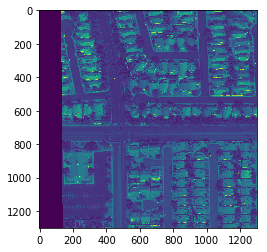

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
#plt.figure(figsize=(12, 10))
plt.imshow(band1); # This is only the red band

Now plot all bands.

(1300, 1300, 3)


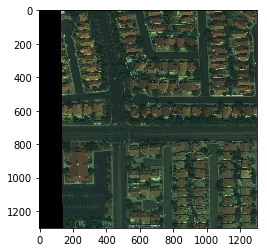

In [17]:
m = (np.rollaxis(np.array([dat_img.read(1),dat_img.read(2),dat_img.read(3)]),0,3)/2048) # 2000 from Nicolas' scripts
print(np.shape(m));
plt.imshow(m);

Weird, not sure why I have this black area on the side. Maybe something went wrong when downloading.

### Using rasterio method show

Using this method, the axis correspond to the coordinates in the CRS.

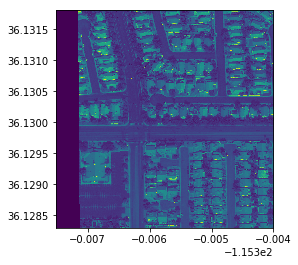

In [18]:
from rasterio.plot import show
show(dat_img); # shows only the first band by default. Looks like I could change the arguments to display the RGB figure. Not important for now.

For fun, check out histogram of color values.

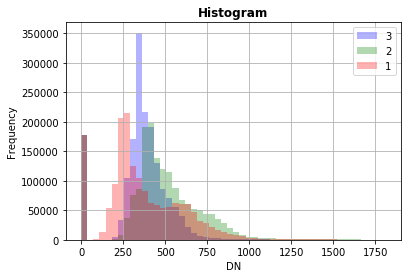

In [19]:
from rasterio.plot import show_hist

show_hist(dat_img, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")

## Add geojson file on top

In [20]:
path_geojson = '../../AOI_2_Vegas_Roads_Train/geojson/spacenetroads/'

Check out this blog for how to read geojson using geopandas library:
https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html

### Read geojson file using geopandas library

In [21]:
import geopandas as gpd
data_json = gpd.read_file(path_geojson+'spacenetroads_AOI_2_Vegas_img' + str(img_idx) + '.geojson')
print(type(data_json))
print(data_json.head(2)) # ... ok cool

<class 'geopandas.geodataframe.GeoDataFrame'>
  bridge_typ heading lane_numbe lane_number one_way_ty paved  road_id  \
0          2       0          2           2          2     1    10755   
1          2       0          2           2          2     1     8770   

  road_type  origarea   origlen  partialDec  truncated  \
0         5         0  0.000643           1          0   
1         5         0  0.000897           1          0   

                                            geometry  
0  LINESTRING (-115.30621418253 36.12981521211, -...  
1  LINESTRING (-115.30483626555 36.13036295551, -...  


### Visualize geojson

geojsonio is a cool interface! ** With options to share on github, maybe look into it for for final presentation? ** 
And it also shows that some of the lines that are labelled as roads are actually parking lots...

In [22]:
# import geojsonio
# geojsonio.display(data_json.to_json());

This is the default way of plotting geopandas dataframes.

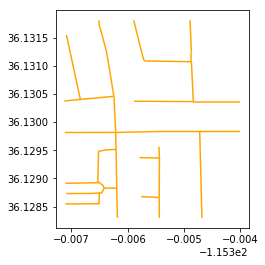

In [23]:
data_json.plot(color='orange');

### Overlay geojson file on raster

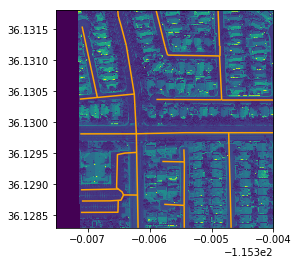

In [24]:
fig,ax=plt.subplots()
show(dat_img,ax=ax)
data_json.plot(ax=ax, color='orange', edgecolor='black')
plt.show()

### Import geojson as raster using rasterio.features.rasterize

In [25]:
import json

with open(path_geojson+'spacenetroads_AOI_2_Vegas_img' + str(img_idx) + '.geojson','r') as f:
    shapes30=json.load(f)

In [26]:
# use geojson
from rasterio.features import rasterize

dat_json_geom = [shape['geometry'] for shape in shapes30['features']]
dat_json_raster = rasterize(dat_json_geom,transform = dat_img.transform,
                            out_shape=(1300, 1300), default_value = 1.0, fill=0, all_touched=True)

dat_json_raster

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
# dat_json_geom

1.0


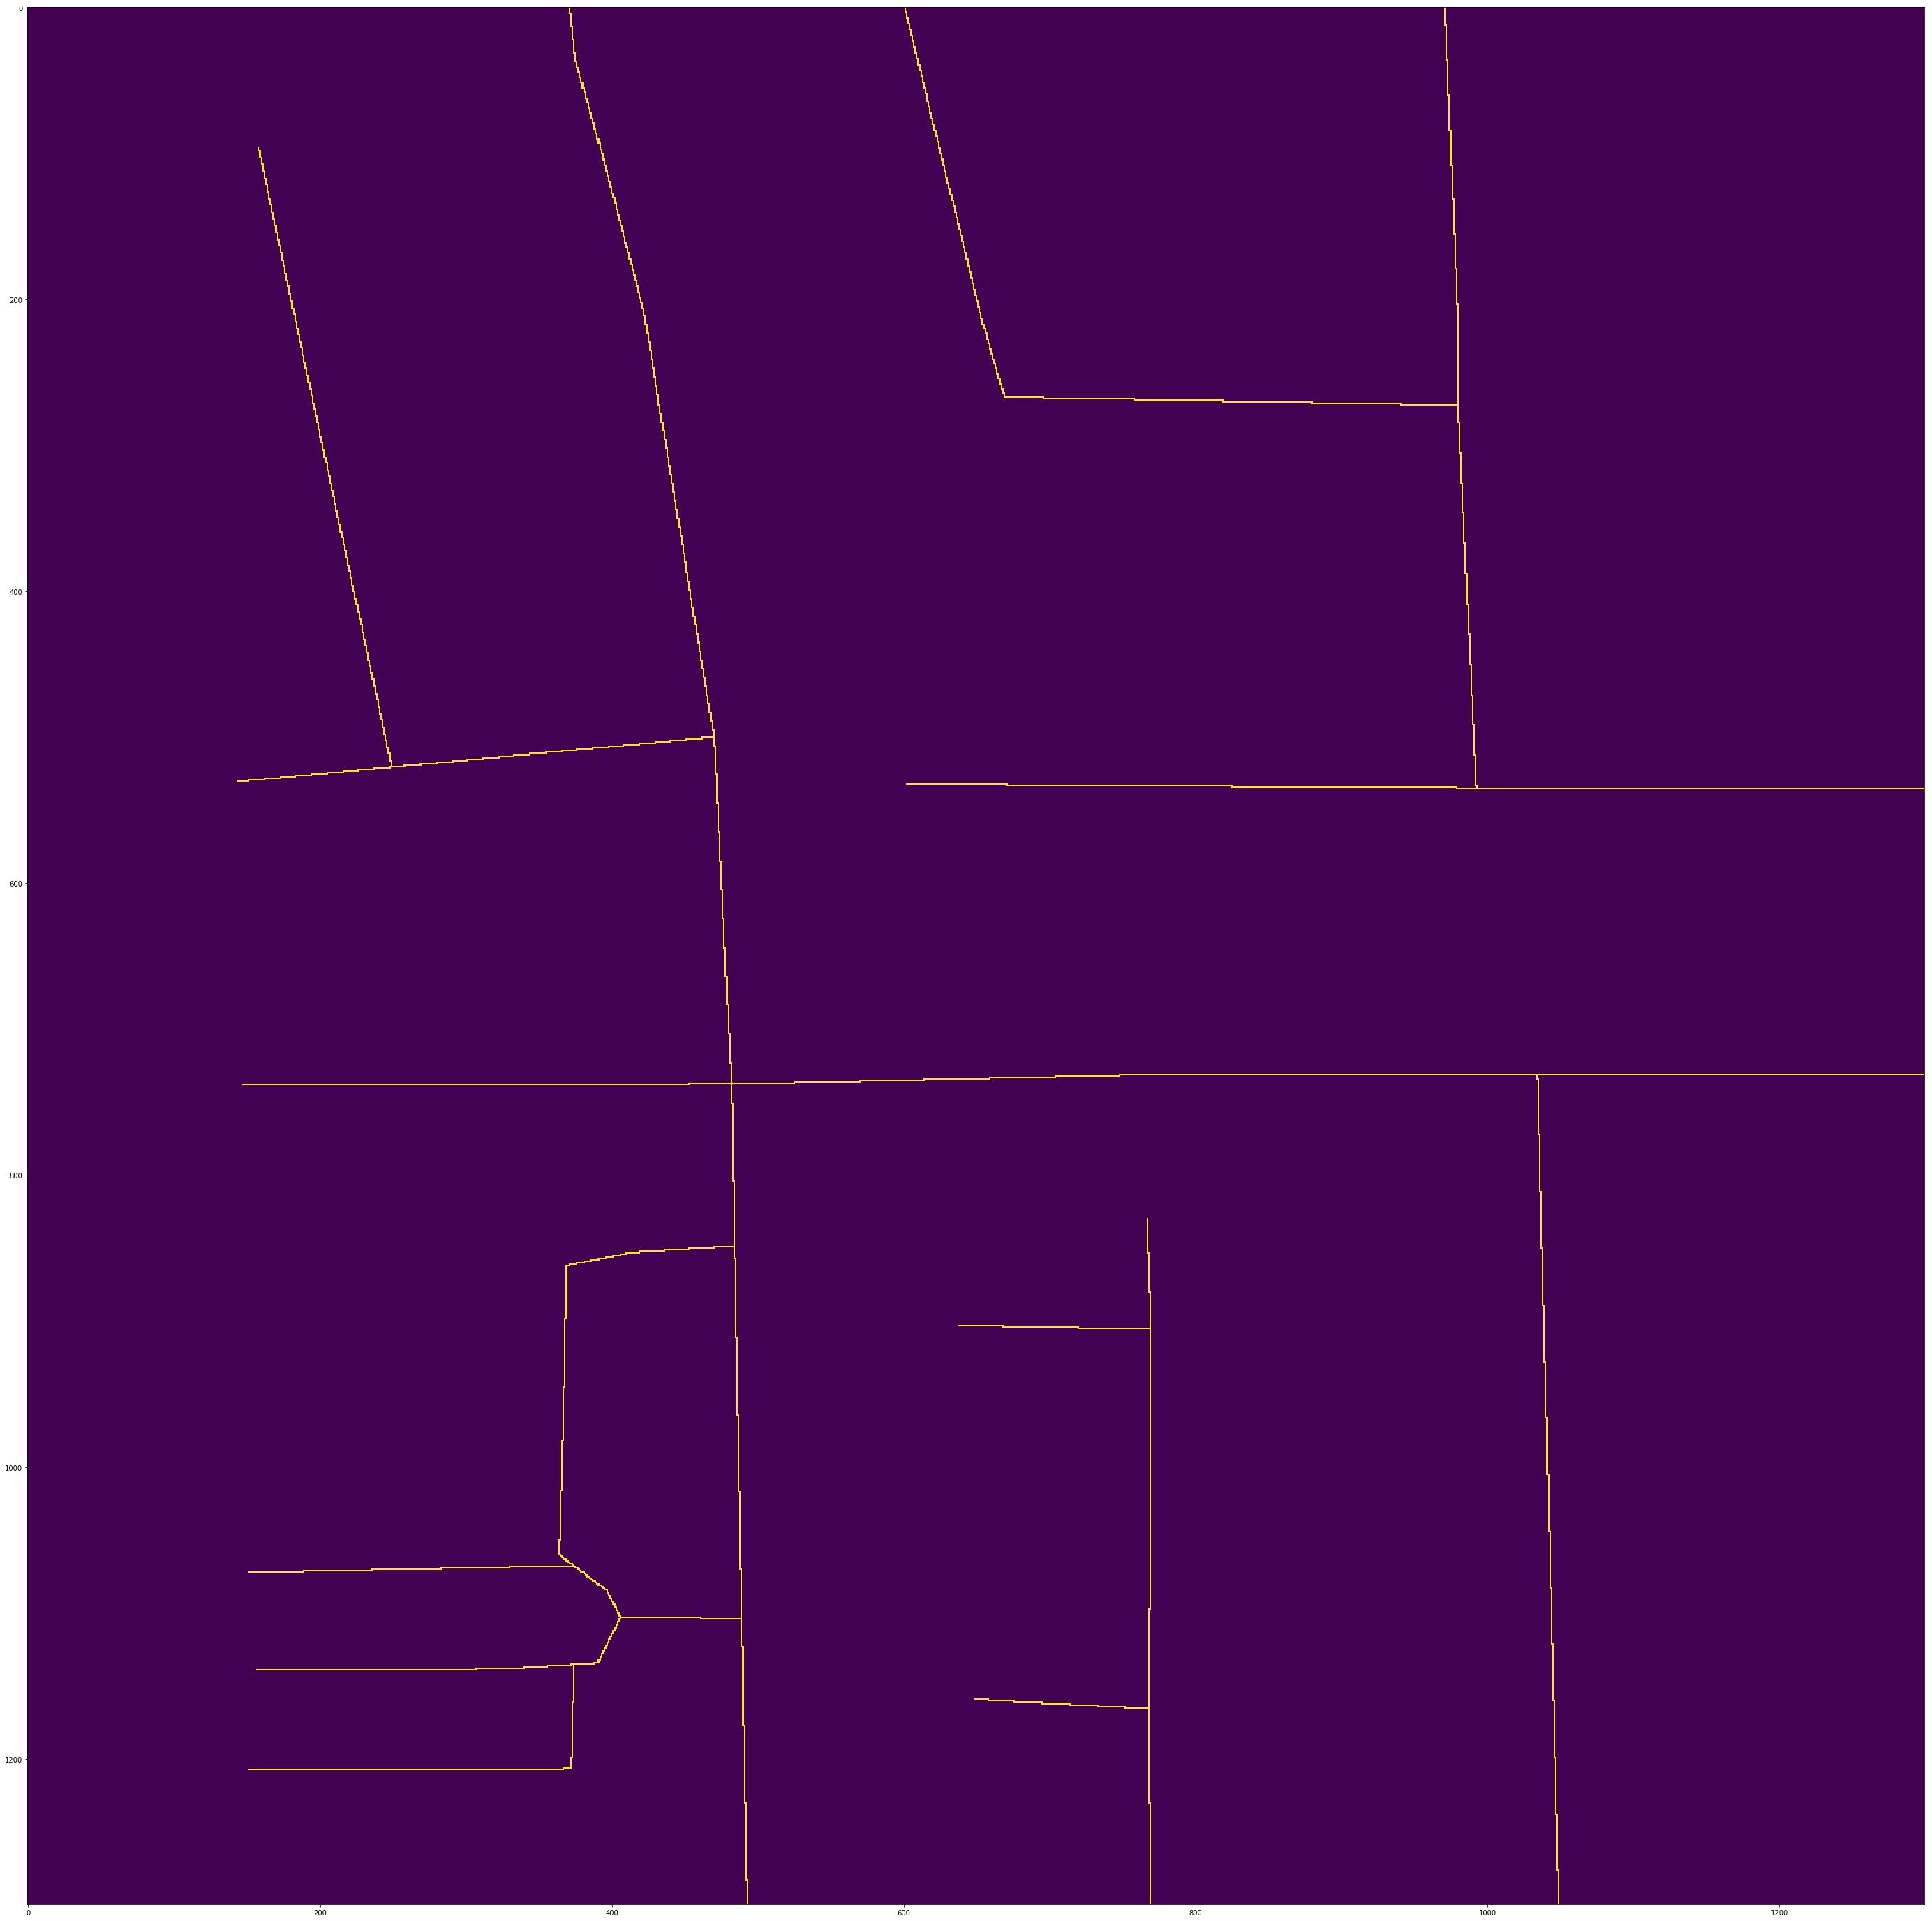

In [28]:
print(np.amax(dat_json_raster))
plt.figure(figsize=(50, 50)) # need to zoom in to see the lines
plt.imshow(dat_json_raster);

## Try out binary dilation to thicken the road

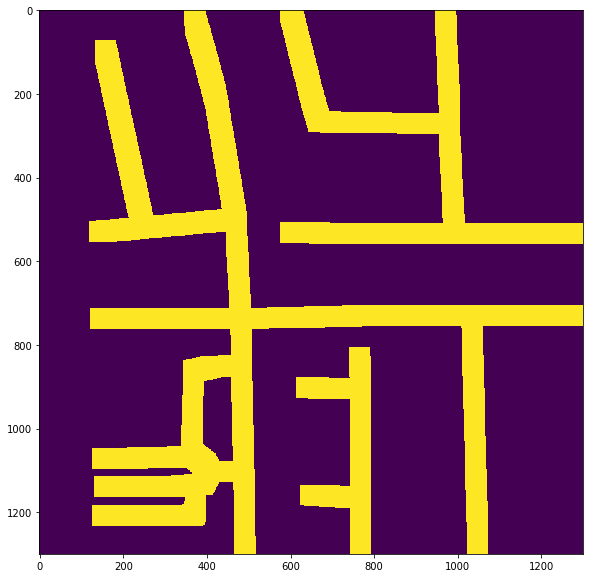

In [29]:
import skimage

from skimage.morphology import binary_dilation

dat_json_raster_dil = binary_dilation(image=dat_json_raster,selem=np.ones((50, 50)))

plt.figure(figsize=(10, 10)) # need to zoom in to see the lines
plt.imshow(dat_json_raster_dil);

Now try to visualize roads on the RGB image.

In [30]:
# probably use mask function from rasterio package

# Visualize subset of images (e.g. training set)

In [31]:
import os
files = os.listdir(path_RGB)
n = len(files)

print(files[0:5])

['RGB-PanSharpen_AOI_2_Vegas_img1.tif', 'RGB-PanSharpen_AOI_2_Vegas_img10.tif', 'RGB-PanSharpen_AOI_2_Vegas_img100.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1001.tif', 'RGB-PanSharpen_AOI_2_Vegas_img1002.tif']


In [32]:
files_geojson = os.listdir(path_geojson)
n_geojson = len(files_geojson)

print(files_geojson[0:5])

['spacenetroads_AOI_2_Vegas_img1.geojson', 'spacenetroads_AOI_2_Vegas_img10.geojson', 'spacenetroads_AOI_2_Vegas_img100.geojson', 'spacenetroads_AOI_2_Vegas_img1001.geojson', 'spacenetroads_AOI_2_Vegas_img1002.geojson']


In [33]:
import re
# extract indices of images
regex = re.compile(r'\d+')
# save all indices in lists
idx_geojson=[int(regex.findall(files_geojson[i])[1]) for i in range(n_geojson)]
idx_rgb=[int(regex.findall(files[i])[1]) for i in range(n)]
# what is the intersection
list_both = list(set(idx_geojson) & set(idx_rgb))

# List of first indices in common
print(list_both[0:20])

[1, 2, 4, 5, 7, 8, 10, 12, 17, 20, 22, 25, 26, 27, 28, 29, 30, 33, 34, 35]


In [34]:
# Number of raster images, number of labels, number of labelled images
print(str(len(idx_rgb)) + ' raster images; ' + str(len(idx_geojson)) + ' labels; ' + str(len(list_both)) + ' labelled images.')

989 raster images; 989 labels; 989 labelled images.


Ok, actually the rasters and the labels overlay exactly.

Now display a subset of images and labels.

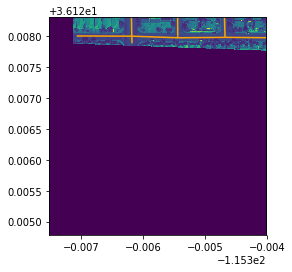

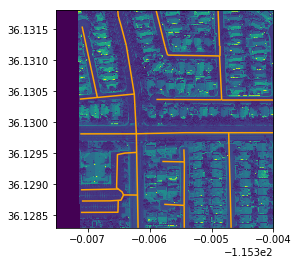

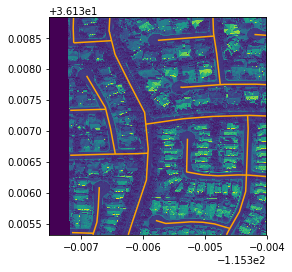

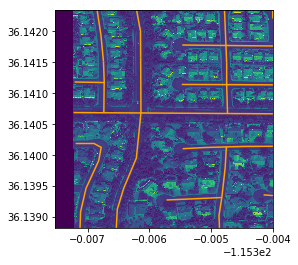

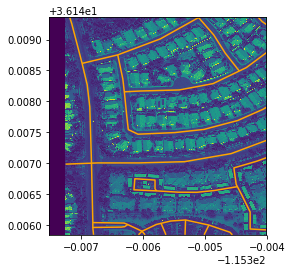

In [35]:
for i_img in list_both[0:5]:
    
    # read raster image
    dat_img = rasterio.open(path_RGB + 'RGB-PanSharpen_AOI_2_Vegas_img'+ str(i_img) +'.tif')
    
    # read geojson image
    data_json = gpd.read_file(path_geojson + 'spacenetroads_AOI_2_Vegas_img' + str(i_img) + '.geojson')
    
    # plot both
    fig,ax=plt.subplots()
    show(dat_img,ax=ax)
    data_json.plot(ax=ax, color='orange', edgecolor='black')
    plt.show()

Ok, so actually it looks like the missing data (black areas) in raster files are accounted for in the geojson files: the roads cover only the part of images with information. So it is not a problem in the download, but in the data itself. It shouldn't be a problem for the rest of the analysis.

## Notes for later

* This looks like the perfect tutorial to learn how to do GIS with Python: https://automating-gis-processes.github.io/CSC18/index.html